We want to understand the time dependence of the data. To do so, we use lag_plot in pandas; if the data of a column is random, then there should be no structure in the lag plot. 

In [1]:
# import libs && tools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [2]:
# import and handle data
df = pd.read_csv('../data/20190606180000-20190606190000.csv')
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna();
df=df.round(decimals=5)  # round to one decimal after precision of devices
df['diff'] = (df['B_VIMIN'] - df['B:VIMIN'])
df2= pd.DataFrame({'diff' : df['diff'], 'err' : df['B:IMINER']})

# define period of TLG
horizon = 60.066; # unit: sec. horizon of TLG..61.-- sec
cycle   = 15; # 15Hz sampling
supercycle = 901; # number of time steps per supercycle (60.066 sec)

C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'B_VIMIN')

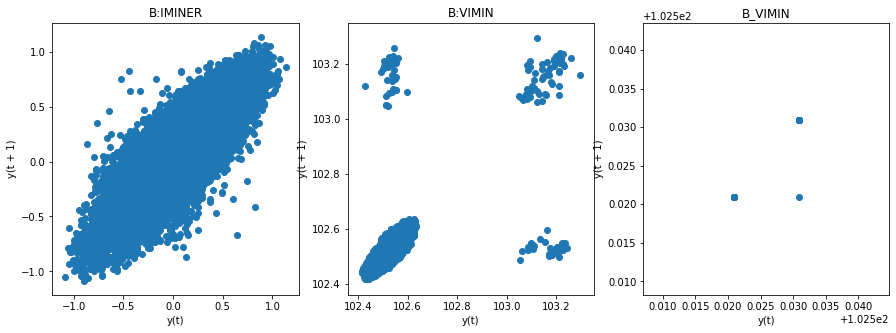

In [3]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
col1,col2,col3='B:IMINER','B:VIMIN','B_VIMIN'

lag_plot(df[col1],ax=ax1)
ax1.set_title(col1)
lag_plot(df[col2],ax=ax2)
ax2.set_title(col2)
lag_plot(df[col3],ax=ax3)
ax3.set_title(col3)

Note the structure in both B:IMINER and B:VIMIN. The linear dependence of time in B:IMINER makes sense, as it is a function of input from the time step before and the current time. B:VIMIN is a little more interesting; B_VIMIN should actually be constant, so to see different data points is also interesting. 

The linearity of the data ofo B:IMINER (and clusters of B:VIMIN) suggests that we should use an auto-regressive model for the data.

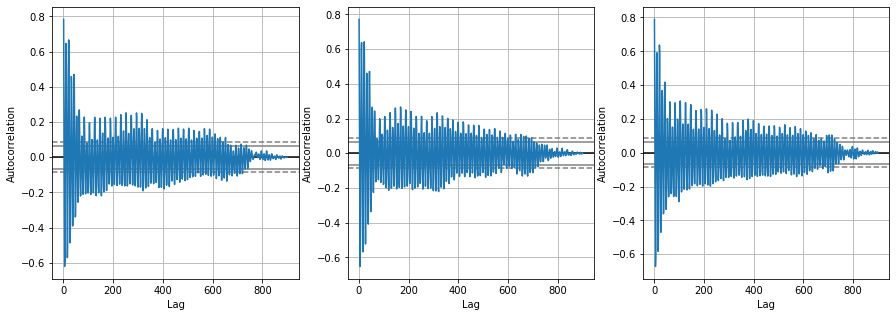

In [4]:
lam = supercycle
t0  = 0
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)

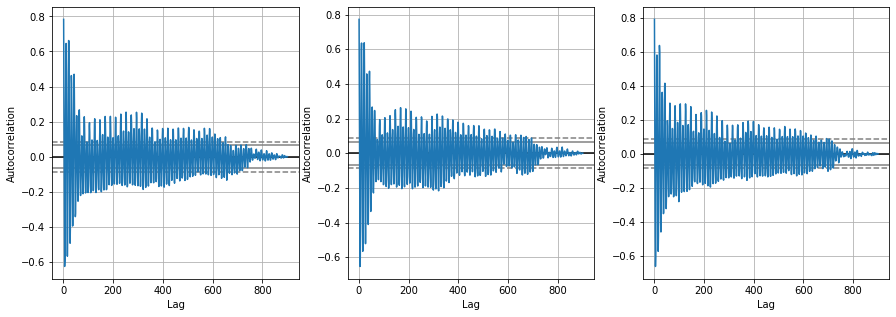

In [5]:
from pandas.plotting import autocorrelation_plot
t0  = cycle
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)

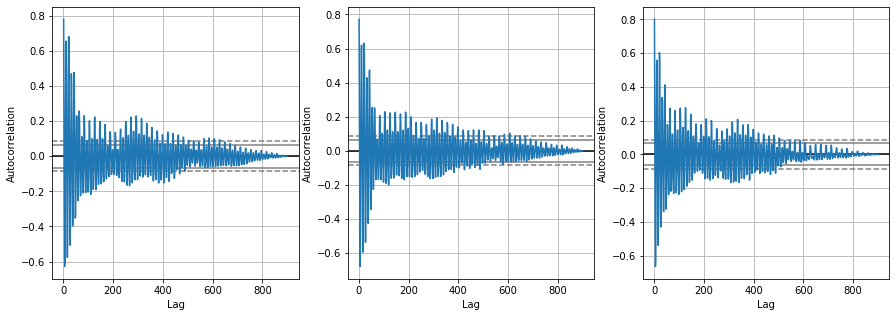

In [6]:
from pandas.plotting import autocorrelation_plot
t0  = 15*cycle
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)

It seems as if no matter where we begin the cycle (i.e. different values of t0), we obtain the same sort of plot of the autocorrelation variables. This observation is consistent with the periodic notion of the series.

Let's look at some of the lag in variables.

In [7]:
'''
SUMMARY: Function to show the autocorrelation of a particular series of data.
FUNCTION: compute_corrs
INPUT   : df    - pandas data frame, data
          col   - string, name of columns
          shift - int, time off-set for correlation 
OUTPUT  : dataframe with cols of lagged time observations of series df[col1]
PURPOSE : to print a table of the correlation 
          correlation of -1 is strongly negative; 
          ---- " -----   +1 is strongly positive.
'''
def compute_corrs(df,col,shift):
    vals = []
    cols = []
    df2 = pd.DataFrame(df[col1].values) # extract series we care about
    cols = ['t']
    for k in range(0,shift+1):
        vals.append(df2.shift(k))# pd.concat([vals,vals.shift(k)], axis=1)
        if k != 0:
            cols.append('t-'+str(k))
    df2 = pd.concat(vals,axis=1)
    df2.columns = cols;
    print(df2.corr())
    return df2

In [8]:
df2=compute_corrs(df,col1,3)

            t       t-1       t-2       t-3
t    1.000000  0.806696  0.443992  0.005505
t-1  0.806696  1.000000  0.806700  0.443993
t-2  0.443992  0.806700  1.000000  0.806700
t-3  0.005505  0.443993  0.806700  1.000000


As expected, the time before most strongly influences the current time step. 
It's expected bc B:IMINER (col1) is a function of B:VIMIN for the PREVIOUS time step.
Then, one would expect B:IMINER to be correlated with itself in the previous time step as well.
Next let's checkout B:VIMINER (col2). Should expect same story.

In [9]:
df3=compute_corrs(df,col2,3)

            t       t-1       t-2       t-3
t    1.000000  0.806696  0.443992  0.005505
t-1  0.806696  1.000000  0.806700  0.443993
t-2  0.443992  0.806700  1.000000  0.806700
t-3  0.005505  0.443993  0.806700  1.000000


Now let's try to create an AR model to predict the next 1sec cycle (i.e. 15 time steps).
The model will show the computed optimal lag (# of previous time steps to include) and output the coefficients applied to each of the lagged time variables. 
Note how little magnitude the current coefficient is and how high the previous (t-1) and the (t-3)^rd time step is.

In [10]:
pred_win=cycle;

Lag: 56
Coefficients: [ 7.37450499e-04  8.49652652e-01 -3.03362339e-02 -2.76961309e-01
 -7.70394035e-02  1.95827363e-02  5.04607139e-03  4.13079957e-02
  1.45614407e-02  3.33392129e-02  5.11206401e-02  5.61871556e-02
  9.90532501e-03  4.43877780e-03  2.57253403e-02 -7.76832998e-03
  6.45257373e-03 -1.76019370e-02 -1.46469463e-02  5.36470462e-02
  4.61335198e-02  3.15092887e-02  3.37983801e-02 -5.34684176e-03
  2.84853898e-02  2.61877432e-02  4.01157772e-03 -1.14210172e-02
 -8.23192612e-03 -1.57010812e-02 -2.17151314e-02 -2.65267895e-02
 -6.81342969e-03 -1.66130149e-02 -1.18760734e-02  5.81303763e-03
 -9.94942451e-04 -1.19808839e-02  2.53158679e-02  4.36174677e-03
  3.88014011e-02  4.39279482e-02  7.33507775e-02 -1.59765661e-02
  3.57442730e-03  2.08972193e-02  3.43916552e-02  3.43738447e-03
 -9.45330375e-03 -1.52979156e-03 -4.48498127e-03 -4.06200115e-03
 -2.02744884e-02 -2.31485370e-02 -3.02312324e-02 -5.55181034e-03
 -1.55449574e-02]
Results for training an AR model for prediction...

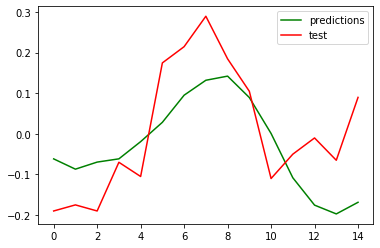

In [11]:
# X=compute_corrs(df,col1,lag).values
X = df[col1].values
train,test = X[1:len(X)-pred_win], X[len(X)-pred_win:]
# train an autoregression model
model=AR(train)
model_fit = model.fit()
print('Lag: %s'%model_fit.k_ar)
print('Coefficients: %s' %model_fit.params)
print('Results for training an AR model for prediction.....')
preds = model_fit.predict(start = len(train), end=len(train)+len(test)-1,dynamic=False)
for i in range(len(preds)):
	print('predicted=%f, observed=%f' % (preds[i], test[i]))
error = mean_squared_error(test, preds)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(range(pred_win), preds,'g',label='predictions')
plt.plot(range(pred_win),test,'r', label='test')
plt.legend()
plt.show()

Lag: 56
Coefficients: [ 1.51909019e+01  5.64022304e-01  1.47039423e-01 -5.17661838e-02
  1.13946779e-01 -1.62040075e-01 -2.39907854e-02  8.46195182e-02
  9.56397017e-02 -3.70906214e-02  9.53607171e-02  8.38642871e-02
  1.50802313e-02 -1.50867966e-01  4.17430869e-02  2.98233226e-03
 -6.36666412e-02  2.57117994e-02 -2.99697117e-02  4.77366187e-02
  2.13954572e-02  3.05172116e-02  6.47872837e-02  4.01223017e-03
 -1.18241736e-02  5.50487691e-03 -2.62875216e-02 -8.33806950e-03
 -1.54118467e-02  7.95126965e-03  5.72816811e-04 -1.13582387e-02
 -1.12546832e-03 -2.26197101e-02 -1.39302748e-02  4.57979367e-02
 -2.51729331e-03 -2.64158942e-02  8.16269583e-03  4.13066149e-04
  1.80930977e-02  2.27692206e-02  3.18347949e-02  4.42099897e-03
 -2.73729529e-02 -1.64594058e-02 -1.44302933e-02 -5.50264374e-04
  5.70421898e-03  9.00776390e-03 -2.17697014e-02  4.08604812e-03
 -4.89126064e-03 -1.61515866e-02 -1.01113688e-02 -9.41537840e-04
  2.09561559e-02]
Results for training an AR model for prediction...

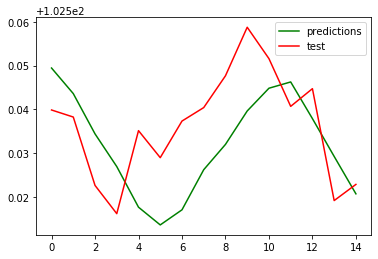

In [12]:
# AR MODEL 2
X = df[col2].values
train,test = X[1:len(X)-pred_win], X[len(X)-pred_win:]
# train an autoregression model
model=AR(train)
model_fit = model.fit()
print('Lag: %s'%model_fit.k_ar)
print('Coefficients: %s' %model_fit.params)
print('Results for training an AR model for prediction.....')
preds = model_fit.predict(start = len(train), end=len(train)+len(test)-1,dynamic=False)
for i in range(len(preds)):
	print('predicted=%f, observed=%f' % (preds[i], test[i]))
error = mean_squared_error(test, preds)
print('Test MSE: %.5f' % error)
# plot results
plt.plot(range(pred_win), preds,'g',label='predictions')
plt.plot(range(pred_win),test,'r', label='test')
plt.legend()
plt.show()

Lag: 56
Coefficients: [ 0.0476925   0.84965265 -0.03033623 -0.27696131 -0.0770394   0.01958274
  0.00504607  0.041308    0.01456144  0.03333921  0.05112064  0.05618716
  0.00990533  0.00443878  0.02572534 -0.00776833  0.00645257 -0.01760194
 -0.01464695  0.05364705  0.04613352  0.03150929  0.03379838 -0.00534684
  0.02848539  0.02618774  0.00401158 -0.01142102 -0.00823193 -0.01570108
 -0.02171513 -0.02652679 -0.00681343 -0.01661301 -0.01187607  0.00581304
 -0.00099494 -0.01198088  0.02531587  0.00436175  0.0388014   0.04392795
  0.07335078 -0.01597657  0.00357443  0.02089722  0.03439166  0.00343738
 -0.0094533  -0.00152979 -0.00448498 -0.004062   -0.02027449 -0.02314854
 -0.03023123 -0.00555181 -0.01554496]
Results for training an AR model for prediction.....
predicted=0.461179, observed=0.403587
predicted=0.449811, observed=0.410314
predicted=0.457619, observed=0.403587
predicted=0.461213, observed=0.457399
predicted=0.480227, observed=0.441704
predicted=0.501586, observed=0.567265
pr

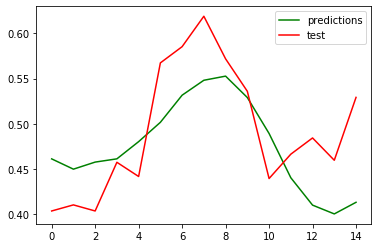

In [13]:
# X=compute_corrs(df,col1,lag).values
X = df[col1].values
X = (X- np.min(X))/(np.max(X)-np.min(X))
train,test = X[1:len(X)-pred_win], X[len(X)-pred_win:]
# train an autoregression model
model=AR(train)
model_fit = model.fit()
print('Lag: %s'%model_fit.k_ar)
print('Coefficients: %s' %model_fit.params)
print('Results for training an AR model for prediction.....')
preds = model_fit.predict(start = len(train), end=len(train)+len(test)-1,dynamic=False)
for i in range(len(preds)):
	print('predicted=%f, observed=%f' % (preds[i], test[i]))
error = mean_squared_error(test, preds)
print('Test MSE: %.5f' % error)
# plot results
plt.plot(range(pred_win), preds,'g',label='predictions')
plt.plot(range(pred_win),test,'r', label='test')
plt.legend()
plt.show()

48108
Lag: 56
Coefficients: [ 1.87039786e-02  5.64022304e-01  1.47039423e-01 -5.17661838e-02
  1.13946779e-01 -1.62040075e-01 -2.39907854e-02  8.46195182e-02
  9.56397017e-02 -3.70906214e-02  9.53607171e-02  8.38642871e-02
  1.50802313e-02 -1.50867966e-01  4.17430869e-02  2.98233225e-03
 -6.36666412e-02  2.57117994e-02 -2.99697117e-02  4.77366187e-02
  2.13954572e-02  3.05172116e-02  6.47872837e-02  4.01223017e-03
 -1.18241736e-02  5.50487691e-03 -2.62875216e-02 -8.33806950e-03
 -1.54118467e-02  7.95126965e-03  5.72816811e-04 -1.13582387e-02
 -1.12546832e-03 -2.26197101e-02 -1.39302748e-02  4.57979367e-02
 -2.51729331e-03 -2.64158942e-02  8.16269583e-03  4.13066149e-04
  1.80930977e-02  2.27692206e-02  3.18347949e-02  4.42099897e-03
 -2.73729529e-02 -1.64594058e-02 -1.44302933e-02 -5.50264374e-04
  5.70421898e-03  9.00776390e-03 -2.17697014e-02  4.08604812e-03
 -4.89126064e-03 -1.61515866e-02 -1.01113688e-02 -9.41537839e-04
  2.09561559e-02]
Results for training an AR model for predict

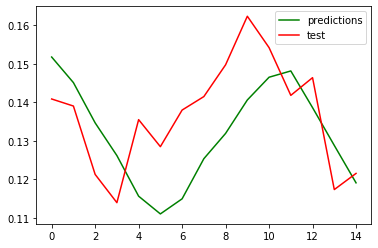

In [17]:
pred_win = int(cycle)
X = df[col2].values
print(len(X))
X = (X- np.min(X))/(np.max(X)-np.min(X))
train,test = X[1:len(X)-pred_win], X[len(X)-pred_win:]
# train an autoregression model
model=AR(train)
model_fit = model.fit()
print('Lag: %s'%model_fit.k_ar)
print('Coefficients: %s' %model_fit.params)
print('Results for training an AR model for prediction.....')
preds = model_fit.predict(start = len(train), end=len(train)+len(test)-1,dynamic=False)
#for i in range(len(preds)):
#	print('predicted=%f, observed=%f' % (preds[i], test[i]))
error = mean_squared_error(test, preds)
print('Test MSE: %.5f' % error)
# plot results
plt.plot(range(pred_win), preds,'g',label='predictions')
plt.plot(range(pred_win),test,'r', label='test')
plt.legend()
plt.show()